# Text classification with Reuters-21578 datasets

### See: https://kdd.ics.uci.edu/databases/reuters21578/README.txt for more information

In [ ]:
%pylab inline

In [648]:
import re
import xml.sax.saxutils as saxutils

from numpy import *

from bs4 import BeautifulSoup

from gensim.models.word2vec import Word2Vec

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM

from multiprocessing import cpu_count

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.lancaster import *
from nltk.stem.wordnet import *

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import model_selection

from pandas import DataFrame
import pandas as pd

from sklearn.cross_validation import train_test_split
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
import nltk
nltk.download('punkt')


## General constants (modify them according to you environment)

In [ ]:
# Set Numpy random seed
random.seed(1000)

# Newsline folder and format
data_folder = './reuters_data/'

# Word2Vec number of features
num_features = 500
# Limit each newsline to a fixed number of words
document_max_num_words = 200
# Selected categories
selected_categories = ['pl_usa']

csv_df = pd.read_csv('./data/reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

## Prepare documents and categories

In [ ]:
# Create category dataframe
all_topics = [ re.sub('topic\.', '', col) for col in csv_df.columns if col.startswith('topic.') ]
print('\n', 'num topics:', len(all_topics))
pd.DataFrame(all_topics, columns=['topic name']).head(15)

# Create category dataframe
news_categories = DataFrame(data={'Name':all_topics, 'Type': 'Topics', 'Newslines':np.zeros(len(all_topics))})



In [ ]:
news_categories

In [ ]:
def update_frequencies(categories):
    for category in categories:
        idx = news_categories[news_categories.Name == category].index[0]
        f = news_categories.get_value(idx, 'Newslines')
        news_categories.set_value(idx, 'Newslines', f+1)
    
def to_category_vector(categories, target_categories):
    vector = zeros(len(target_categories)).astype(float32)
    
    for i in range(len(target_categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0
    
    return vector

## Top 20 categories (by number of newslines)

In [ ]:
roughly_even_topics_set = set(roughly_even_topics)
df = df[df.apply(
    lambda row: len(row['topic_list']) == 1 and set(row['topic_list']).issubset(roughly_even_topics_set),
    axis = 1
)]

binarizer = MultiLabelBinarizer(classes = roughly_even_topics)

topic_lists = df.apply(lambda row : row['topic_list'][0], axis = 1).values.reshape(len(df), 1)
roughly_even_topics_binarized = binarizer.fit_transform(topic_lists)
roughly_even_topics_binarized[:5]

## Tokenize newsline documents

In [ ]:
df_train = df[df['purpose'] == 'train']
df_test = df[df['purpose'] == 'test']

n_classes = len(all_topics)

print('total docs', len(df))
print('num train examples', len(df_train))
print('num test examples', len(df_test))
df.head()


In [ ]:
def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string):
    return re.sub(r'([0-9]+ ?)+', '<num> ', string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ 
        stemmer.stem(word) if hasattr(stemmer, 'stem') else stemmer.lemmatize(word)
        for word in re.split(' ', string) if not word in stop_words 
    ])

In [ ]:
stop_words = stopwords.words('english')

stemmer = LancasterStemmer()

In [ ]:
def pre_process(string):
    s = lower_case(string)
    s = fix_lt(s)
    s = remove_reuter(s)
    s = strip_punctuation(s)
    s = remove_stop_words(s, stop_words)
    s = compact_whitespace(s)
    s = replace_numeric_with_literal(s)
    s = stem(s, stemmer)
    return s.strip()

In [ ]:
def pre_process_df(df):
    return df.apply(lambda row : pre_process(row['doc.title'] + ' ' + row['doc.text']), axis = 1).values

In [ ]:
pre_processed_train = pre_process_df(df_train)

In [ ]:
pre_processed_test = pre_process_df(df_test)

In [ ]:
def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

counts_by_word = get_counts_by_word(
    df.apply(lambda row : row['doc.title'] + ' ' + row['doc.text'], axis = 1).values
)

In [ ]:
counts_by_word_pre_processed_train = get_counts_by_word(pre_processed_train)

In [ ]:
num_words = 3000
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False)[4:num_words].head(20)

In [ ]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False).plot()

In [ ]:
top_words = list(counts_by_word_pre_processed_train.items())
top_words.sort(key = lambda it: it[1])
top_words.reverse()
top_words = [ word for word, count in top_words[:num_words] ]
print(len(top_words))
top_words[:10]

In [ ]:
def replace_rare_words_with_literal(string, top_words):
    return ' '.join([ (word if word in top_words else '') for word in re.split(' ', string) ])

pre_processed_train = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_train
]

pre_processed_test = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_test
]

## Word2Vec Model
### See: https://radimrehurek.com/gensim/models/word2vec.html and https://code.google.com/p/word2vec/ for more information

In [ ]:
# Load an existing Word2Vec model
w2v_model = Word2Vec.load(data_folder + 'reuters.word2vec')

In [ ]:
allsentence = pre_process_df(df)
print("type",type(allsentence), "shape", allsentence.shape)

In [ ]:
allwords = [] 
for s in allsentence: 
    allwords.append(s.split())

print(allwords)

In [ ]:
# Create new Gensim Word2Vec model
w2v_model = Word2Vec(allwords, size=num_features, min_count=1, window=10, workers=cpu_count())
w2v_model.init_sims(replace=True)
w2v_model.save(data_folder + 'reuters.word2vec')

In [ ]:
w2v_model["head"]

## Vectorize each document

In [ ]:
num_categories = len(selected_categories)


empty_word = zeros(num_features).astype(float32)

def tokensToVec(documents):
    X = zeros(shape=(len(documents), document_max_num_words, num_features)).astype(float32)
    
    for idx, document in enumerate(documents):
        for jdx, word in enumerate(document.split()):
            if jdx == document_max_num_words:
                break
            else:
                if word in w2v_model:
                    X[idx, jdx, :] = w2v_model[word]
                else:
                    X[idx, jdx, :] = empty_word
    return X

## Split training and test sets

In [ ]:
X_train = tokensToVec(pre_processed_train)
X_test = tokensToVec(pre_processed_test)

def to_category_vector(categories, target_categories):
    vector = zeros(len(target_categories)).astype(float32)
    
    for i in range(len(target_categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0
    
    return vector
def single_label(dft):
    topics = dft.apply(lambda row : row['topic_list'][0], axis = 1).values
    
    result = []
    for i in topics:
        result.append(to_category_vector(i,roughly_even_topics))
    
    return np.array(result)


Y_train = single_label(df_train)
Y_test = single_label(df_test)

## Create Keras model

In [ ]:
print("document_max_num_words=", document_max_num_words)
print("num_features=", num_features)

num_categories = len(roughly_even_topics)
print("num_categories ", num_categories)

df_test[4:9]

In [ ]:
model = Sequential()

model.add(LSTM(int(document_max_num_words*1.5), input_shape=(document_max_num_words, num_features)))
model.add(Dropout(0.3))
model.add(Dense(num_categories))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train and evaluate model

In [644]:
# Train model
history = model.fit(X_train, Y_train, batch_size=256, nb_epoch=40, validation_data=(X_test, Y_test))

# Evaluate model
score, acc = model.evaluate(X_test, Y_test, batch_size=256)
    
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 943 samples, validate on 377 samples
Epoch 1/40
943/943 [==============================] - 15s 16ms/step - loss: 0.4736 - acc: 0.8015 - val_loss: 0.4669 - val_acc: 0.8021
Epoch 2/40
943/943 [==============================] - 16s 17ms/step - loss: 0.4726 - acc: 0.8040 - val_loss: 0.4614 - val_acc: 0.8058
Epoch 3/40
943/943 [==============================] - 15s 16ms/step - loss: 0.4682 - acc: 0.8057 - val_loss: 0.4571 - val_acc: 0.8064
Epoch 4/40
943/943 [==============================] - 15s 16ms/step - loss: 0.4680 - acc: 0.8066 - val_loss: 0.4538 - val_acc: 0.8090
Epoch 5/40
943/943 [==============================] - 15s 16ms/step - loss: 0.4573 - acc: 0.8089 - val_loss: 0.4432 - val_acc: 0.8101
Epoch 6/40
943/943 [==============================] - 15s 16ms/step - loss: 0.4424 - acc: 0.8108 - val_loss: 0.4303 - val_acc: 0.8101
Epoch 7/40
943/943 [==============================] - 15s 16ms/step - loss: 0.4381 - acc: 0.8091 - val_loss: 0.4364 - val_acc: 0.7804
Epoch 8/40
943/9

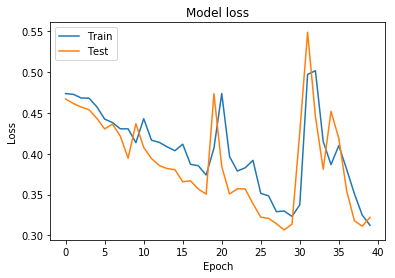

In [645]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [650]:
def binarize(t) :
    maxId = np.argmax(t, axis=1)
    binv = np.zeros((t.shape))
    for idx, pos in enumerate(maxId):
        binv[idx,pos] = 1

    return binv

In [652]:
y_test_predicted_labels = model.predict(X_test)

predicted = binarize(y_test_predicted_labels)

print("predicted shape ", y_test_predicted_labels.shape)
print("y_test    shape ", Y_test.shape)
print("predicted       ", y_test_predicted_labels)
print("predicted bin.  ", predicted)
print("Y test          ", Y_test)


accuracy_score(Y_test, predicted)
avg='weighted'
print('f1_score  :', f1_score(Y_test, predicted, average = avg))
#print('precision :', average_precision_score(y_test, predicted, average = avg))

predicted shape  (377, 5)
y_test    shape  (377, 5)
predicted        [[0.08150746 0.06085464 0.04174109 0.89758706 0.02675804]
 [0.30722836 0.04638441 0.01558248 0.05453105 0.45735103]
 [0.12207572 0.06197668 0.03075525 0.7771699  0.04118343]
 ...
 [0.09244932 0.55251944 0.06191282 0.32627192 0.04774492]
 [0.23054412 0.03688275 0.0144028  0.4739815  0.10527511]
 [0.09669794 0.7699706  0.06727951 0.14524351 0.06307757]]
predicted bin.   [[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
Y test           [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
f1_score  : 0.5591181420911702


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [603]:
t = array(
    [[0.2226171,  0.29442668, 0.05272774, 0.25584626, 0.22210537],
     [0.22258776, 0.219336527, 0.05255532, 0.35723976, 0.22122917]])
maxId = np.argmax(t, axis=1)
print(maxId)
print(t.shape)
binv = np.zeros((t.shape))
for idx, pos in enumerate(maxId):
    binv[idx,pos] = 1

print(binv)

[1 3]
(2, 5)
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


## other

In [ ]:
print(X_train)

In [ ]:
print(Y_train)

In [ ]:
print('X shape', X_train.shape)
print(X_train)

In [ ]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

In [ ]:
# Spot Check Algorithms
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)